In [1]:
from gurobipy import *
# Example data for problem
cost = [100, 100, 100, 100, 200, 200];
value = [50, 150, 150, 150, 300, 50];
edges = [[4,0], [4,1], [4,2], [5,1], [5,2], [5,3]];

m = Model()
n = len(cost) # number of blocks

# Indicator variable for each block
x = {}
for i in range(n):
   x[i] = m.addVar(vtype=GRB.BINARY, name="x%d" % i)

m.update()

# Set objective
m.setObjective(quicksum((value[i] - cost[i])*x[i] for i in range(n)), GRB.MAXIMIZE)

# Add constraints
for edge in edges:
   u = edge[0]
   v = edge[1]
   m.addConstr(x[u] <= x[v])

m.optimize()

Academic license - for non-commercial use only
Optimize a model with 6 rows, 6 columns and 12 nonzeros
Variable types: 0 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 150.0000000
Found heuristic solution: objective 200.0000000
Presolve removed 6 rows and 6 columns
Presolve time: 0.47s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.59 seconds
Thread count was 1 (of 4 available processors)

Solution count 2: 200 150 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+02, best bound 2.000000000000e+02, gap 0.0000%


In [8]:
# https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
# pequeña modificacion de la clase FancyArrowPatch para plotear flechas en python
import numpy as np
from numpy import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [7]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#input_path = '../Blasor_inputs/MB_LoA20_v2.csv'
input_path = '../Daniel_inputs/block_model.csv'
MB = pd.read_csv(input_path)

In [28]:
cols = MB.keys().tolist()
print('Nombres de las columnas:',cols)

Nombres de las columnas: ['xcentre', 'ycentre', 'zcentre', 'calcosina', 'cut', 'cufe', 'rec_max_block']


In [9]:
# recuperar las dimensiones del modelo de bloques
# se utilizan las dimensiones en todas las direcciones
# para determinar el conjunto de aracos. Considerar 
#primero una cantidad mas pequeña de bloques, i.e. de niveles
# en el eje z
MB_sorted = MB.sort_values(by=['zcentre'],ascending=False)
MB_sorted = MB_sorted.loc[MB_sorted['zcentre']<447.5]
MB_sorted = MB_sorted.loc[MB_sorted['xcentre']<72660]
MB_sorted = MB_sorted.loc[MB_sorted['ycentre']<477960]

pos_z = MB_sorted[['zcentre']].values
pos_x = MB_sorted[['xcentre']].values
pos_y = MB_sorted[['ycentre']].values

# eliminar repeticiones de las posiciones
# para determinar dimensiones del modelo
# de bloques
pos_z_unique = np.unique(pos_z)
pos_y_unique = np.unique(pos_y)
pos_x_unique = np.unique(pos_x)

# usar la notacion de lerchs-grossmann algorithm with
# variables slopes angles.
numx = np.size(pos_x_unique)
numy = np.size(pos_y_unique)
numz = np.size(pos_z_unique)

print('numx: ',numx)
print('numy: ',numy)
print('numz: ',numz)

# determinar dimensiones del modelo de bloques
zdim =  pos_z_unique[1]-pos_z_unique[0]
xdim =  pos_x_unique[1]-pos_x_unique[0]
ydim =  pos_y_unique[1]-pos_y_unique[0]

print('xdim: ',xdim)
print('ydim: ',ydim)
print('zdim: ',zdim)

numx:  3
numy:  3
numz:  3
xdim:  20.0
ydim:  20.0
zdim:  15.0


In [55]:
theta = np.arctan(4/4)
theta

0.7853981633974483

In [33]:
import math
# determianr conjunto de arcos
# dados los angulos theta en las
# direcciones principales. Como primer
# ejercicio se consideraron todos iguales
theta_n = np.pi/4
theta_s = np.pi/6
theta_w = np.pi/6
theta_e = np.pi/6
arcos = []
dicc_semiejes = {}
for k in range(1,numz+1):
    for i in range(1,numx+1):
        for j in range(1,numy+1):
            for t in range(1,k):
                #dx1 = (k-t)*zdim/np.tan(theta_w)
                #dy1 = (k-t)*zdim/np.tan(theta_s)
                #dx2 = (k-t)*zdim/np.tan(theta_e)
                #dy2 = (k-t)*zdim/np.tan(theta_n)
                
                dx1 = t*zdim/np.tan(theta_w)
                dy1 = t*zdim/np.tan(theta_s)
                dx2 = t*zdim/np.tan(theta_e)
                dy2 = t*zdim/np.tan(theta_n)
                
                m1 = dx1/xdim
                n1 = dy1/ydim
                m2 = dx2/xdim
                n2 = dy2/ydim
                print('###################################')
                print('nivel t=',t,'.bloque base:',(i,j,k),'.semi-ejes: dx1 = %.2f, dy1 = %.2f, dx2 = %.2f, dy2 = %.2f' % (dx1,dy1,dx2,dy2))
                print('Parametros de las cantidades de bloques: m1=%.2f, n1=%.2f, m2=%.2f, n2=%.2f' % (m1,n1,m2,n2))
                for m in range(max(math.floor(i-m2),1),min(numx,math.ceil(i+m1))+1):
                    for n in range(max(math.floor(j-n2),1),min(numy,math.ceil(j+n1))+1):
                        print()
                        a = xdim*(i-m)
                        b = ydim*(j-n)
                        print('*********** Distancia del bloque X_{%.2f,%.2f,%.f} ***********' % (m,n,k-t))
                        print('a=%.2f, b=%.2f' % (a,b))
                        a2 = a**2
                        b2 = b**2
                        if m>=i and n>=j:
                            Value = a2/(dx1**2) +b2/(dy1**2)
                        elif m>=i and n<=j:
                            Value = a2/(dx1**2) +b2/(dy2**2)
                        elif m<=i and n<=j:
                            Value = a2/(dx2**2) +b2/(dy2**2)
                        elif m<=i and n>=j:
                            Value = a2/(dx2**2) +b2/(dy1**2)
                        if Value<=1:
                            arcos.append([(i,j,k),(m,n,k-t)])
                            

###################################
nivel t= 1 .bloque base: (1, 1, 2) .semi-ejes: dx1 = 25.98, dy1 = 25.98, dx2 = 25.98, dy2 = 15.00
Parametros de las cantidades de bloques: m1=1.30, n1=1.30, m2=1.30, n2=0.75

*********** Distancia del bloque X_{1.00,1.00,1} ***********
a=0.00, b=0.00

*********** Distancia del bloque X_{1.00,2.00,1} ***********
a=0.00, b=-20.00

*********** Distancia del bloque X_{1.00,3.00,1} ***********
a=0.00, b=-40.00

*********** Distancia del bloque X_{2.00,1.00,1} ***********
a=-20.00, b=0.00

*********** Distancia del bloque X_{2.00,2.00,1} ***********
a=-20.00, b=-20.00

*********** Distancia del bloque X_{2.00,3.00,1} ***********
a=-20.00, b=-40.00

*********** Distancia del bloque X_{3.00,1.00,1} ***********
a=-40.00, b=0.00

*********** Distancia del bloque X_{3.00,2.00,1} ***********
a=-40.00, b=-20.00

*********** Distancia del bloque X_{3.00,3.00,1} ***********
a=-40.00, b=-40.00
###################################
nivel t= 1 .bloque base: (1, 2, 2) .s

[(2, 2, 2), (3, 2, 2), (3, 3, 2), (1, 2, 1), (1, 3, 1), (2, 1, 1), (2, 2, 1), (2, 3, 1), (3, 1, 1), (3, 2, 1), (3, 3, 1)]


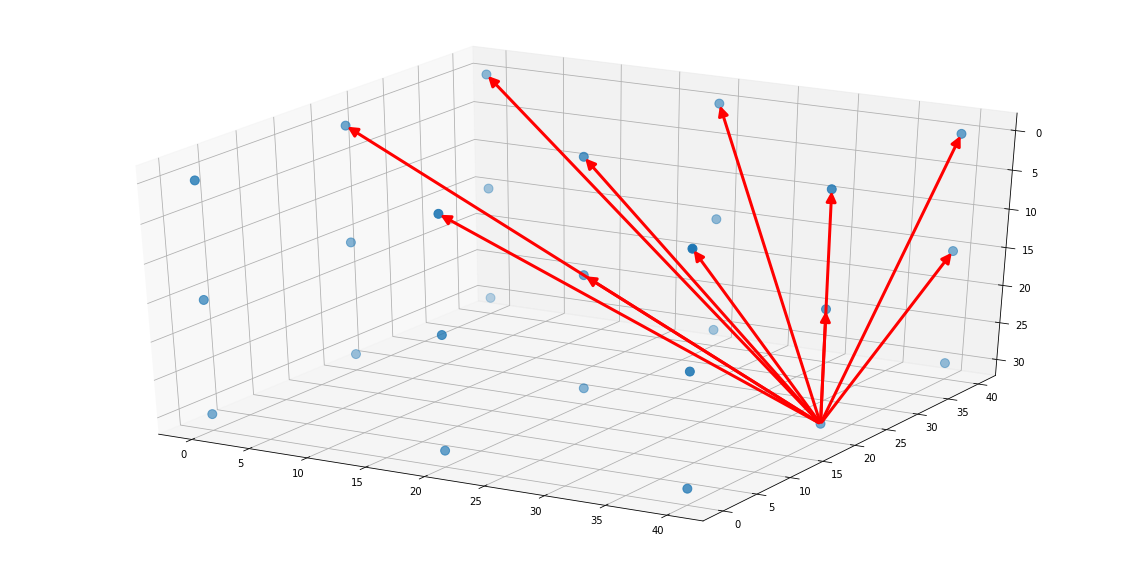

In [34]:
bloque_base = (3,2,3)
sacar = []
for arco in arcos:
    bloque_tail = arco[0]
    bloque_head = arco[1]
    if bloque_base==bloque_tail:
        sacar.append(bloque_head)
print(sacar)

MB_grafico = MB_sorted[['xcentre','ycentre','zcentre']]-(min(MB_sorted[['xcentre']].values),min(MB_sorted[['ycentre']].values),min(MB_sorted[['zcentre']].values))
ejex = MB_grafico[['xcentre']]
ejey = MB_grafico[['ycentre']]
ejez = MB_grafico[['zcentre']]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
plt.gca().invert_zaxis()

for v in sacar:
    #ax.plot([mean_x,v[0]], [mean_y,v[1]], [mean_z,v[2]], color='red', alpha=0.8, lw=3)
    #I will replace this line with:
    a = Arrow3D([(bloque_base[0]-1)*20, (v[0]-1)*20], [(bloque_base[1]-1)*20, (v[1]-1)*20], 
                [(bloque_base[2]-1)*15, (v[2]-1)*15], mutation_scale=20, 
                lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.scatter(ejex,ejey,ejez,s=80)

In [1]:
# ejemplo de grafico in mayavi
import numpy as np
import mayavi.mlab as m
m.init_notebook()

p0 = [0.799319, -3.477045e-01, 0.490093]
p1 = [0.852512, 9.113778e-16, -0.522708]
p2 = [0.296422, 9.376042e-01, 0.181748]

origin = [0,0,0]
X, Y, Z = zip(origin,origin,origin) 
U, V, W = zip(p0,p1,p2)
m.quiver3d(X,Y,Z,U,V,W)

Notebook initialized with x3d backend.
